In [21]:
from load_dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statsmodels.api as smf
from scipy import stats

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [22]:
dataset_path = os.environ['mac_parklane_path']
df = pd.read_csv(dataset_path)
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


In [23]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7) & (df['sys_eff']>=0.4) & (df['sys_eff']<=0.9)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# efficiency column reduce by air system efficiency
fil_df['sys_eff'] = fil_df['sys_eff'] - fil_df['air_eff']

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

# chiller configuration
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# ct approach
fil_df['ct_approach'] = fil_df['h_cwst'] - fil_df['wea_ct_wb']
fil_df = fil_df[fil_df['ct_approach']<=4]

# ct_tot_kw
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=20)]

# weekend column
fil_df['weekend'] = pd.to_datetime(fil_df['timestamp']).dt.dayofweek
fil_df['weekend'] = fil_df['weekend'].apply(lambda x:1 if x<=4 else 2)

# time column
def time_dec(x):
    if x<=12:
        t = 1
    elif x<=17:
        t = 2
    else:
        t = 3
    
    return t

fil_df['time'] = pd.to_datetime(fil_df['timestamp']).dt.hour
fil_df['time'] = fil_df['time'].apply(time_dec)

print("total number of rows after filter is {}".format(len(fil_df)))

# columns manipulation
fil_df['ch_sysef'] = np.int32(os.environ['ch_sysef_const']) ** fil_df['ch_sysef']
fil_df['h_cwst'] = fil_df['h_cwst'] ** np.float32(os.environ['h_cwst_const'])
fil_df['h_cwrt'] = fil_df['h_cwrt'] ** np.float32(os.environ['h_cwrt_const'])
fil_df['ct_tot_kw'] = fil_df['ct_tot_kw'] ** np.float32(os.environ['ct_tot_const'])
fil_df['lift'] = fil_df['lift'] * np.int32(os.environ['lift_const'])
fil_df['wea_ct_wb'] = fil_df['wea_ct_wb'] ** np.float32(os.environ['wea_wb_const'])

# selecting related features only
ch_sysef_df = fil_df[['ch_sysef','ch_run', 'h_cwst', 'h_cwrt', 'ct_tot_kw', 'lift', 'sys_cl', 'wea_ct_wb', 'ct_approach', 'time', 'weekend']]
ch_sysef_df = ch_sysef_df.drop_duplicates().dropna().reset_index()

# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="h_cwst")
sns.displot(ch_sysef_df, x="h_cwrt")
sns.displot(ch_sysef_df, x="ct_tot_kw")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="wea_ct_wb")
sns.displot(ch_sysef_df, x="weekend")
sns.displot(ch_sysef_df, x="time")

/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_20256/542419230.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fil_df['weekend'] = pd.to_datetime(fil_df['timestamp']).dt.dayofweek


KeyboardInterrupt: 

# Feature Extraction

In [ ]:
chiller_feats = ["ch_sysef", "h_cwst", "h_cwrt", "ct_tot_kw", "lift", "sys_cl", 'ct_approach', 'wea_ct_wb', 'time', 'weekend']
df_chiller = fil_df[chiller_feats]
X = df_chiller
y = fil_df[["ch_sysef"]]

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Pearsons Correlation

In [ ]:
corr_values = r_regression(X,y)

table_df = pd.DataFrame(
    data=corr_values.reshape(1, -1),
    columns=chiller_feats)
table_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,ch_sysef,h_cwst,h_cwrt,ct_tot_kw,lift,sys_cl,ct_approach,wea_ct_wb,time,weekend
0,1.0,0.363497,0.515587,0.5078,0.486729,0.307202,-0.24098,0.444613,-0.106716,-0.024085


## Spearmans Correlation

In [ ]:
# spearmans correlation
res_corr = []
for feat in chiller_feats:
    res = stats.spearmanr(fil_df[feat], y)
    res_corr.append(res.statistic)

res_corr = np.array(res_corr)
table_df = pd.DataFrame(
    data=res_corr.reshape(1, -1),
    columns=chiller_feats
)
table_df


,ch_sysef,h_cwst,h_cwrt,ct_tot_kw,lift,sys_cl,ct_approach,wea_ct_wb,time,weekend
0,1.0,0.274111,0.529725,0.466746,0.521189,0.360247,-0.274587,0.471045,-0.101283,-0.019591


comment
the last 5 features are the most significant contributor to chiller efficiency
which are cooling tower power inputs, cooling load, heat rejection, power input, normalization isn't necessary for pearson's test

## PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

n_list = [i for i in range(1,11)]
r_squared = {}

for n in n_list:
    pca_n = make_pipeline(PCA(n_components = n), LinearRegression())
    pca_n.fit(X_train, y_train)

    r_squared_value = pca_n.score(X_test, y_test)
    r_squared[n] =  r_squared_value


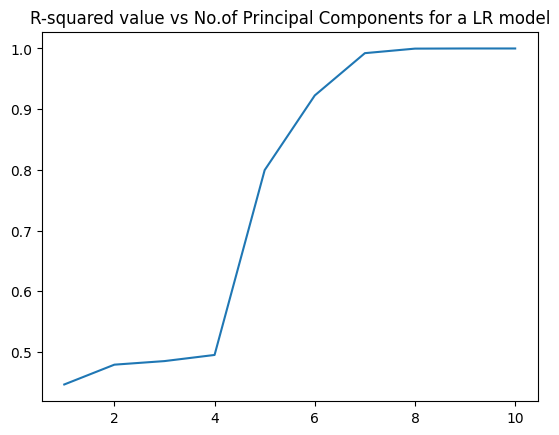

In [ ]:
n = r_squared.keys()
values = r_squared.values()
plt.plot(n,values)
plt.title("R-squared value vs No.of Principal Components for a LR model")
plt.show()

In [ ]:
pd.set_option('mode.use_inf_as_na', True)


/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_20256/1991739887.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [ ]:
five_feat_df = fil_df[["ct_1_kw", "ct_2_kw", "h_cwf", "h_cwrt", "h_chwst", "ch_sysef"]]
five_feat_df = five_feat_df.reset_index(drop=True)

five_feat_df.corr()

In [ ]:
fil_df[chiller_feats].corr()

,ch_sysef,h_cwst,h_cwrt,ct_tot_kw,lift,sys_cl,ct_approach,wea_ct_wb,time,weekend
ch_sysef,1.000000,0.363497,0.515587,0.507800,0.486729,0.307202,-0.240980,0.444613,-0.106716,-0.024085
h_cwst,0.363497,1.000000,0.628628,0.162599,0.527542,0.494240,0.070024,0.704904,-0.168159,-0.092008
h_cwrt,0.515587,0.628628,1.000000,0.350085,0.835556,0.592500,-0.121277,0.560054,-0.313258,-0.107970
ct_tot_kw,0.507800,0.162599,0.350085,1.000000,0.306826,0.425934,-0.561272,0.520282,-0.177000,-0.034523
lift,0.486729,0.527542,0.835556,0.306826,1.000000,0.493178,-0.110496,0.476132,-0.228173,-0.077993
sys_cl,0.307202,0.494240,0.592500,0.425934,0.493178,1.000000,0.016293,0.360628,-0.623247,-0.218438
ct_approach,-0.240980,0.070024,-0.121277,-0.561272,-0.110496,0.016293,1.000000,-0.658164,-0.051572,-0.143226
wea_ct_wb,0.444613,0.704904,0.560054,0.520282,0.476132,0.360628,-0.658164,1.000000,-0.089289,0.032596
time,-0.106716,-0.168159,-0.313258,-0.177000,-0.228173,-0.623247,-0.051572,-0.089289,1.000000,0.030530
weekend,-0.024085,-0.092008,-0.107970,-0.034523,-0.077993,-0.218438,-0.143226,0.032596,0.030530,1.000000


<Axes: >

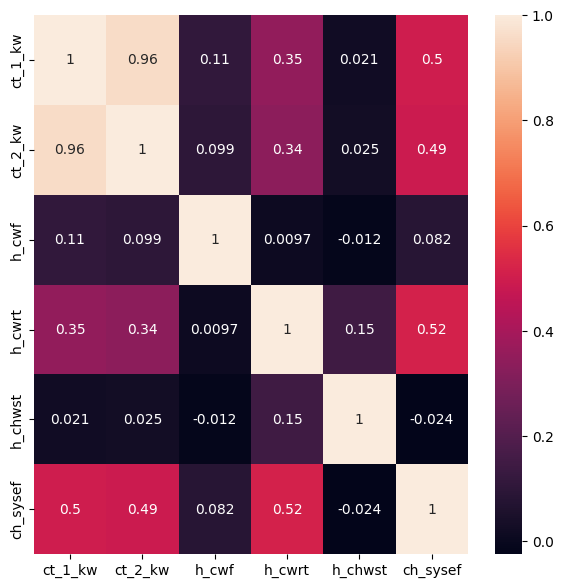

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(five_feat_df.corr(), annot=True)

In [ ]:
# sns.pairplot(five_feat_df)
# picture in msTeams
fil_df["total_ct_kw"] = fil_df["ct_1_kw"] + fil_df["ct_2_kw"]
fil_df["total_ct_kw"]

646       7.056000
648       7.088001
649       7.104001
650       7.072001
651       7.056001
            ...   
727422    4.320000
727423    4.208000
727424    4.192000
727425    4.096000
727426    4.176000
Name: total_ct_kw, Length: 176037, dtype: float64

In [ ]:
# Train Test Split
five_Feat = fil_df[["total_ct_kw", "h_cwf", "h_cwrt", "h_chwst"]] # due to multicollinearity, ct_2_kw is removed
y = fil_df[["ch_sysef"]]

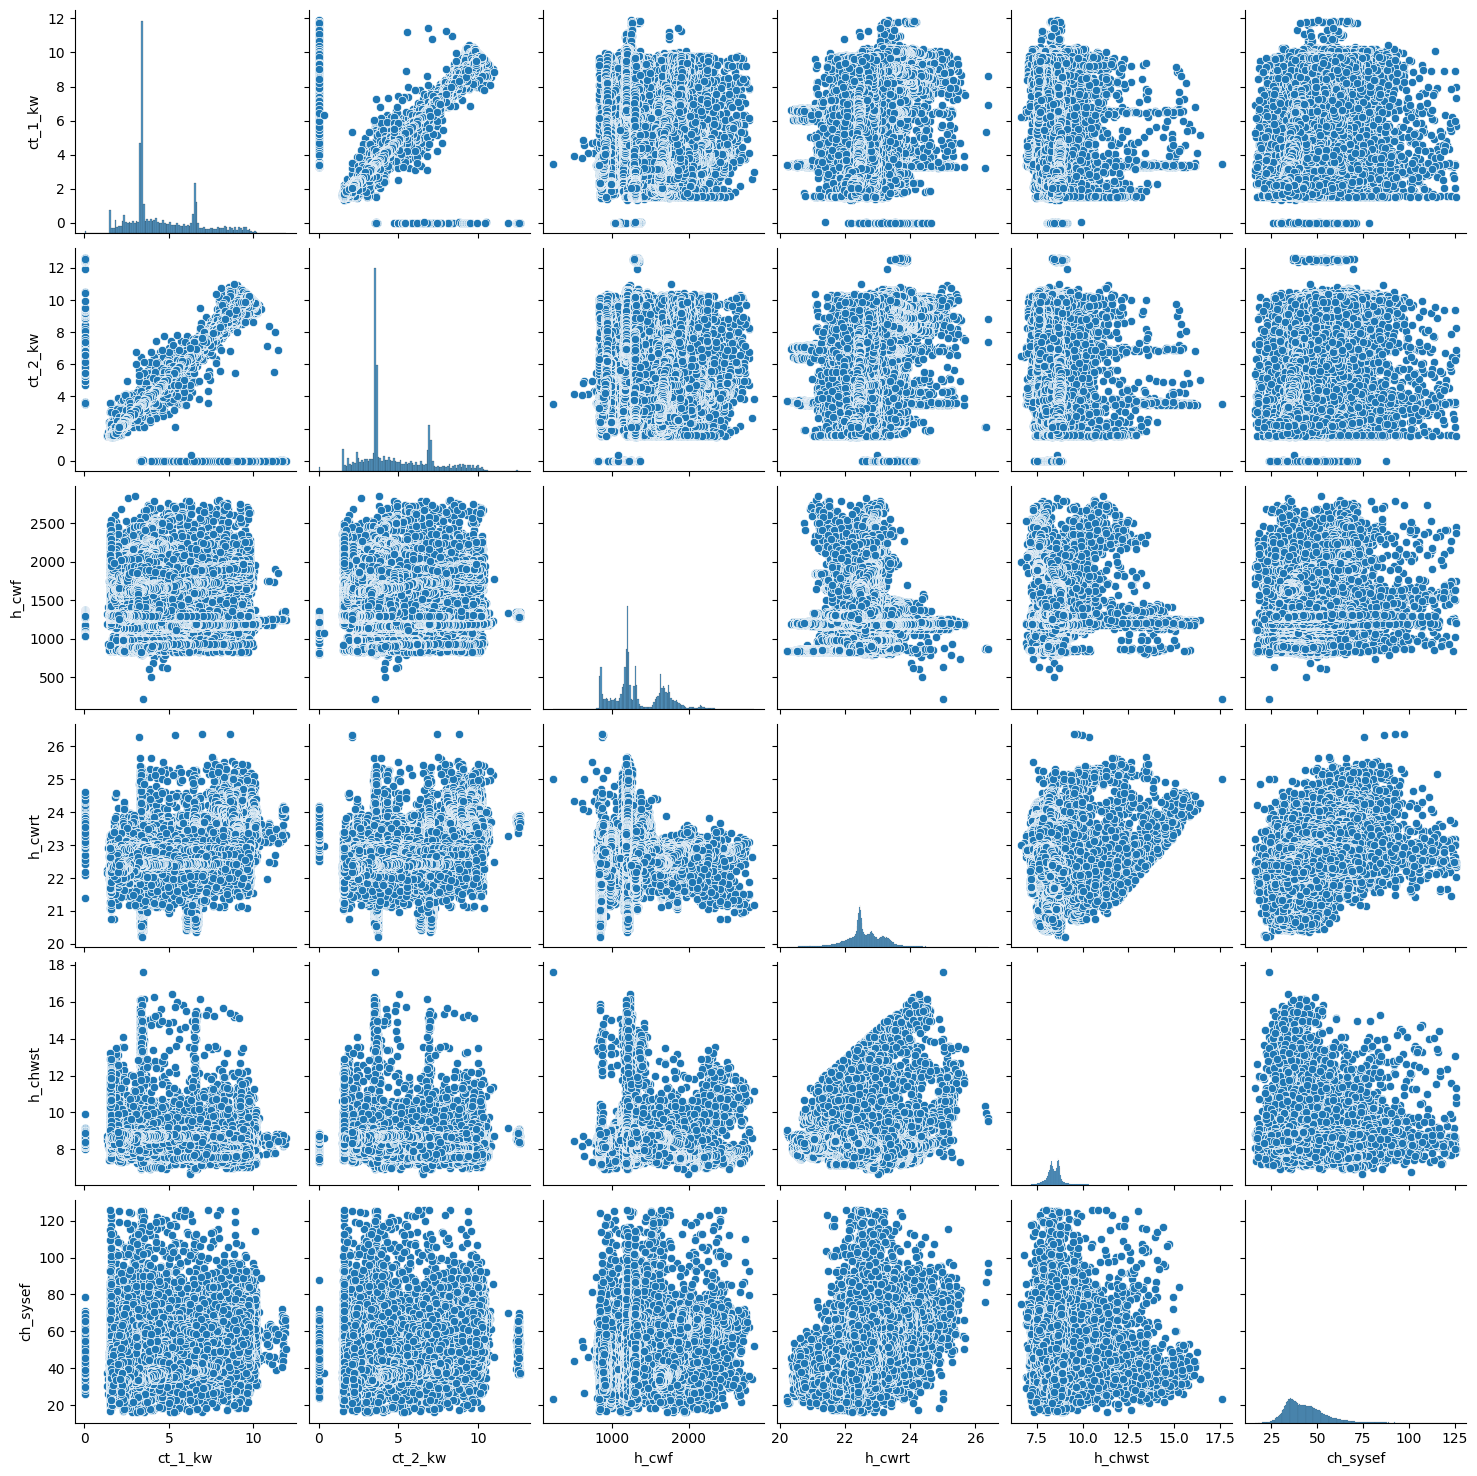

In [ ]:
sns.pairplot(five_feat_df)

# Polynomial Regression

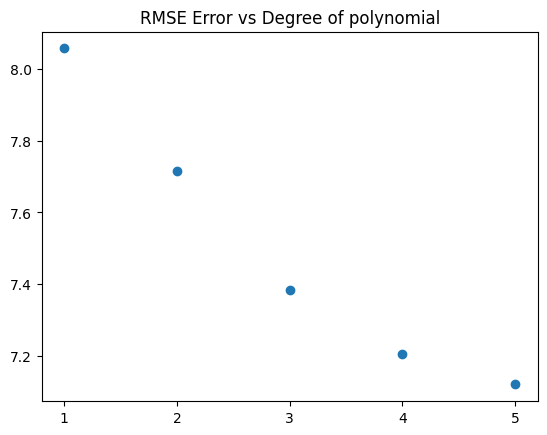

In [ ]:
degrees = [i for i in range(1, 6)]
rmse = []
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(five_Feat)
    five_Feat_train, five_Feat_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.2, random_state=42)

    poly_reg = LinearRegression()
    poly_reg.fit(five_Feat_train, y_train)

    poly_reg_y_predicted = poly_reg.predict(five_Feat_test)
    rmse.append(np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted)))


plt.scatter(degrees, rmse)
plt.title("RMSE Error vs Degree of polynomial")
plt.xticks(degrees)
plt.show()



In [ ]:
# comparison with ordinary LinReg
lin_reg = LinearRegression()
lin_reg.fit(five_Feat_train, y_train)
lin_reg_y_predicted = lin_reg.predict(five_Feat_test)
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, lin_reg_y_predicted))
print("RMSE error for ordinary Linear Regression is {}".format(lin_reg_rmse))

RMSE error for ordinary Linear Regression is 7.120992070990343


polynomial regression with degree of 1 actually produces lower MSE

# Ridge Regression

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.05902e-41): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.88379e-40): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.54953e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.83035e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.

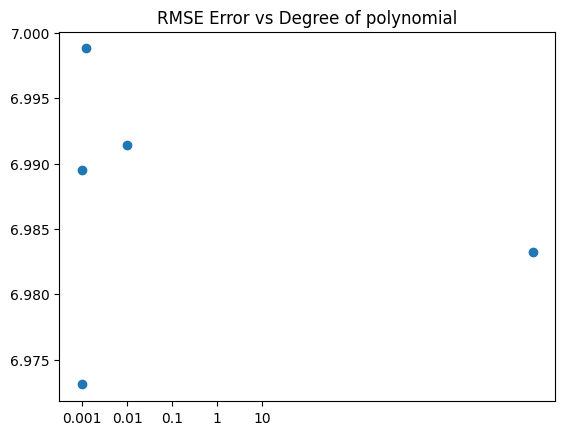

In [ ]:
alphas = [0.001, 0.01, 0.1, 1, 10]
rmse = []
for alpha in alphas:
    ridgeReg = Ridge(alpha=alpha)

    ridgeReg.fit(five_Feat_train, y_train)

    ridge_reg_y_predicted = ridgeReg.predict(five_Feat_test)
    ridge_reg_rmse = np.sqrt(mean_squared_error(y_test, ridge_reg_y_predicted))
    
    rmse.append(ridge_reg_rmse)
plt.scatter(alphas, rmse)
plt.title("RMSE Error vs Degree of polynomial")
plt.xticks(range(len(alphas)), alphas)
plt.show()